## Get Figure of predictions and uncertainty maps for each technique.

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%autoreload

In [3]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import segmentation_models_pytorch as smp
from natsort import natsorted
from uloss_wmh.fitting.fitter import StandardLitModelWrapper
from uloss_wmh.fitting.optimizer_constructor import OptimizerConfigurator, standard_configurations
from tqdm import tqdm

In [4]:
from uloss_wmh.evaluate.eval_metrics.weighted_average_challenge_metrics import weighted_challenge_metrics

In [5]:
from uloss_wmh.evaluate.eval_metrics.challenge_metrics import do_challenge_metrics, per_model_chal_stats, challenge_results_combined_lists

In [6]:
# loss functions
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss, DiceCELoss, DiceFocalLoss
from uloss_wmh.loss_functions.brier import Brier, BrierPlusDice
from uloss_wmh.loss_functions.odyssey_dice import SoftDiceLoss, DC_and_topk_loss
from uloss_wmh.loss_functions.odyssey_ND_Crossentropy import TopKLoss, CrossentropyND
from uloss_wmh.loss_functions.dice_plusplus import DicePlusPlusLoss

### loading the train, val and test datasets in 3D this time.

In [7]:
from ulw_data.torch_dataset.challenge_dataset_3D import load_3D_wmh_chal
from ulw_data.torch_dataset.challenge_data_pipeline import train_data_pipeline

In [8]:
collated_folder = "/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/preprocessed/collated/"
train_ds, val_ds = train_data_pipeline(ds_path=collated_folder, val_proportion=0.15, seed=5, transforms=None, dims=3)

In [9]:
test_dss = load_3D_wmh_chal(ds_path=collated_folder, train=False, combine=False, remove_mask_channel=False)

In [10]:
len(test_dss)

5

In [11]:
test_dss[3][0]['uid']

'test_Singapore_70'

In [12]:
singpare = test_dss[3]

### compute the metrics for each metric

In [13]:
model_base = smp.Unet(
        encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=2,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=3,                      # model output channels (number of classes in your dataset)
    )

In [14]:
models_root = "/media/benp/NVMEspare/project_data/loss_func_proj/models/new_models"
model_dirs = os.listdir(models_root)

In [15]:
model_dirs

['dice_plusplus_gamma2_2',
 'spherical_topk10_1',
 'spherical_topk10_2',
 'spherical_topk1_1',
 'spherical_topk1_2',
 'spherical_topk1_3',
 'xent_e_1',
 'xent_e_2',
 'xent_e_3',
 'xent_topk10_1',
 'xent_topk10_2',
 'xent_topk10_3',
 'xent_topk1_1',
 'xent_topk1_2',
 'xent_topk1_3',
 'xent_unscaled_1',
 'xent_unscaled_2',
 'xent_unscaled_3',
 'dice_plusplus_gamma2_3',
 'dice_plusplus_gamma3_1',
 'dice_plusplus_gamma3_2',
 'dice_plusplus_gamma3_3',
 'dice_plusplus_gamma4_1',
 'dice_plusplus_gamma4_2',
 'dice_plusplus_gamma4_3',
 'dice_standard_1',
 'dice_standard_2',
 'dice_standard_3',
 'dice_temp_scaled_1',
 'dice_temp_scaled_2',
 'dice_temp_scaled_3',
 'spherical_alpha2_1',
 'spherical_alpha2_2',
 'spherical_alpha2_3',
 'brier_power2_1',
 'brier_power2_2',
 'brier_power2_3',
 'brier_topk10_1',
 'brier_topk10_2',
 'brier_topk10_3',
 'brier_topk1_1',
 'brier_topk1_2',
 'brier_topk1_3',
 'dice_4',
 'dice_partial_temp_scale_1',
 'dice_partial_temp_scale_2',
 'dice_partial_temp_scale_3']

In [16]:
custom_optim_config = OptimizerConfigurator(optim='Adam', lr=3e-4, weight_decay=0, scheduler='ReduceOnPlateau', patience=12, threshold=1e-4, factor=0.3, min_lr=1e-6, monitor='train_loss', verbose_lr=True)

In [17]:
#natsorted(os.listdir(f"{models_root}/{model_dirs[0]}"))[1]

### what I want to know

- [ ] calibration curve data
- [ ] fit a line to ECE vs volume, and do the 95% confidence interval (look at stats from one of maria's paper see what I need to report)
- [ ] ueo curve data
- [ ] coverage of individual lesions curve data
- [ ] precision data and recall data

In [18]:
# example images
test_ds = test_dss[3]

In [19]:
def load_model_preds(model, t=1, input_ds=None):
    preds_dss = []
    with torch.no_grad():
        model.eval()
        for ds in [input_ds]:
            preds_domain = []
            for data in tqdm(ds, position=0, leave=True):
                inp = data['image'].cuda().moveaxis(-1, 0)
                inp = inp[:,0:2] # remove the mask channel
                out = model(inp)
                
                if out.shape[1] > 1:
                    out = torch.softmax(out/t, dim=1)
                else:
                    out = torch.sigmoid(out/t)
                
                preds_domain.append(out.moveaxis(0, -1).squeeze().cpu())
            preds_dss.append(preds_domain)
            # break # UNCOMMENT DEBUG
    
    # get combined list of all domains together
    preds = preds_dss[0]
        
    return preds

In [21]:
masks = []
for data in test_ds:
    masks.append(data['image'][-1])

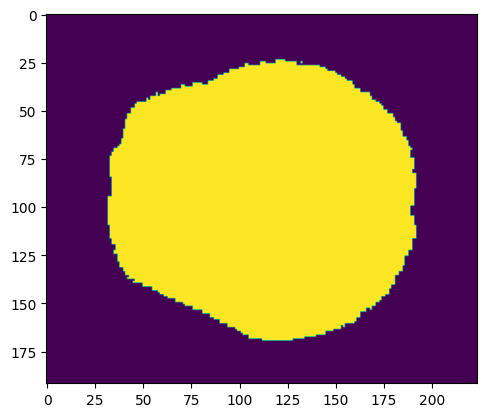

In [23]:
plt.imshow(masks[0][:,:,32])

In [24]:
def plot_image(image, vmin=None, vmax=None, cmap='gray', title=None):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(image[:,:,i+20].T, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.axis('off')
    
    plt.savefig(f"wmh_pred_images/{title}_image.pdf", bbox_inches='tight')
    

In [25]:
def plot_single_slice(image, slice, vmin=None, vmax=None, cmap='gray', title=None):
    # plt.figure(figsize=(3,2))
    # plt.imshow(image[30:-30,30:-30,slice + 20].T, cmap=cmap, vmin=vmin, vmax=vmax)
    # plt.axis('off')
    plt.imsave(f"wmh_pred_images/single_slice_images/{title}_{slice}_image.jpg", image[30:-30,30:-30,slice + 20].T, cmap=cmap, vmin=vmin, vmax=vmax)

In [26]:
scan_id = 2
slice_id = 19
flair = test_ds[scan_id]['image'][0]
plot_single_slice(flair, slice_id, -3, 3, title=f"flair{scan_id}")
slice_id = 12
plot_single_slice(flair, slice_id, -3, 3, title=f"flair{scan_id}")

scan_id = 3
slice_id = 11
flair = test_ds[scan_id]['image'][0]
plot_single_slice(flair, slice_id, -3, 3, title=f"flair{scan_id}")

scan_id = 23
slice_id = 20
flair = test_ds[scan_id]['image'][0]
plot_single_slice(flair, slice_id, -3, 3, title=f"flair{scan_id}")


scan_id = -1
slice_id = 16
flair = test_ds[scan_id]['image'][0]
plot_single_slice(flair, slice_id, -3, 3, title=f"flair{scan_id}")

In [27]:
len(test_ds)

30

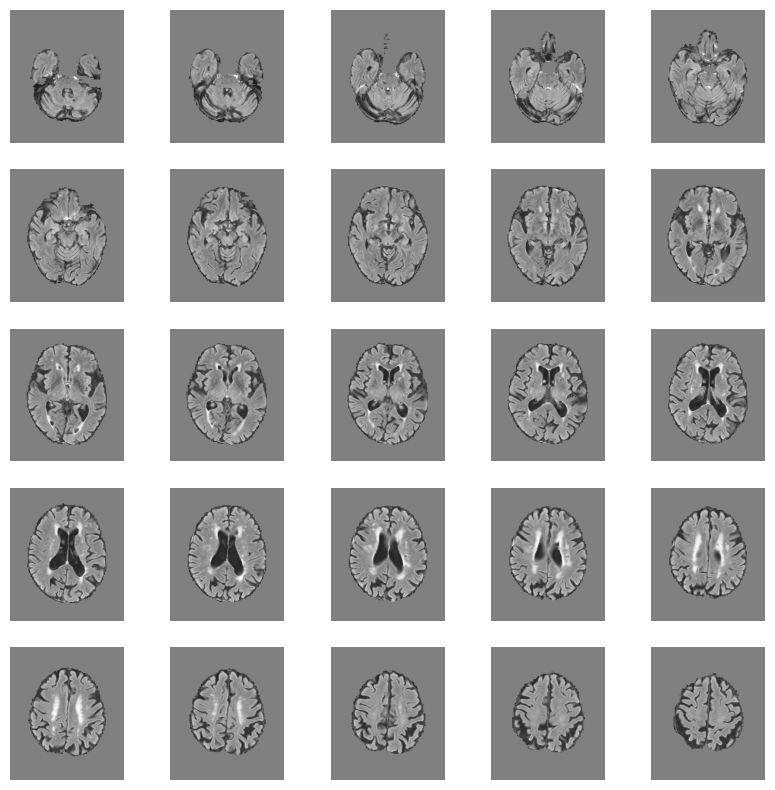

In [28]:
scan_id = 1
flair = test_ds[scan_id]['image'][0]
plot_image(flair, -3, 3, title=f'flair_{scan_id}')
plt.show()

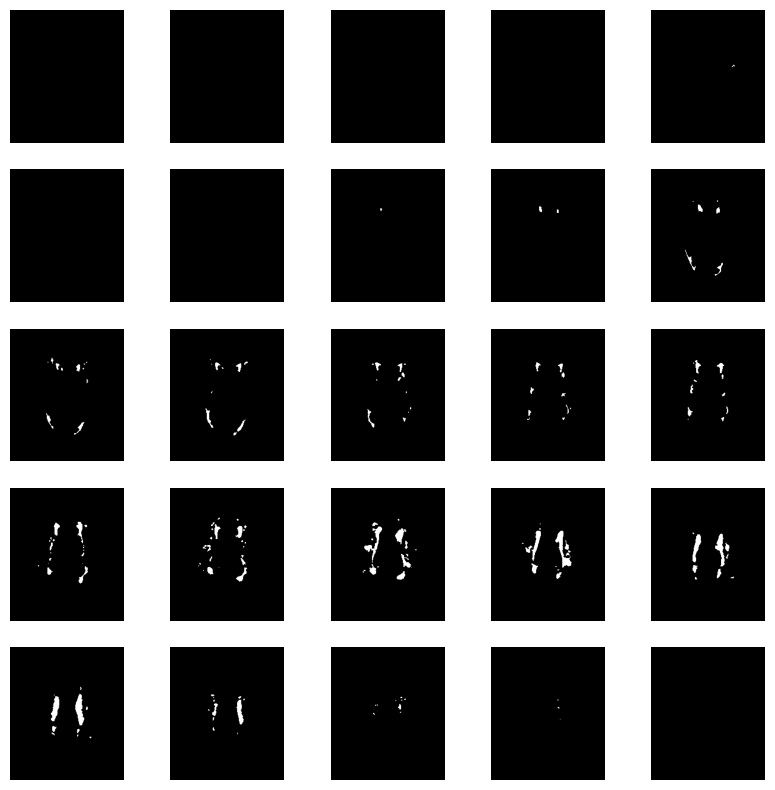

In [29]:
wmh = test_ds[scan_id]['label'][0] == 1
plot_image(wmh, 0, 1, title=f'wmh_{scan_id}')

In [30]:
scan_id = 2
slice_id = 19
wmh = test_ds[scan_id]['label'][0] == 1
plot_single_slice(wmh, slice_id, 0, 1, title=f"wmh{scan_id}")
slice_id = 12
plot_single_slice(wmh, slice_id, 0, 1, title=f"wmh{scan_id}")

scan_id = 3
slice_id = 11
wmh = test_ds[scan_id]['label'][0] == 1
plot_single_slice(wmh, slice_id, 0, 1, title=f"wmh{scan_id}")

scan_id = 23
slice_id = 20
wmh = test_ds[scan_id]['label'][0] == 1
plot_single_slice(wmh, slice_id, 0, 1, title=f"wmh{scan_id}")


scan_id = -1
slice_id = 16
wmh = test_ds[scan_id]['label'][0] == 1
plot_single_slice(wmh, slice_id, 0, 1, title=f"wmh{scan_id}")

In [31]:
def softmax_ent(preds):
    ent_maps = []
    for p in tqdm(preds):
        e = (-p * (p+1e-8).log()).sum(dim=0)
        ent_maps.append(e)
        
    return ent_maps

In [32]:
def fast_dice(pred, target):
    p1 = (pred == 1)
    t1 = (target == 1)
    intersection = (pred == 1) & (target == 1)
    numerator = 2 * intersection.sum()
    denominator = p1.sum() + t1.sum()
    return int((numerator/(denominator + 1e-30)).item() * 100)

In [33]:
selected_dirs = ['spherical_topk1_1', 'xent_e_1', 'dice_plusplus_gamma3_1', 'dice_standard_1', 'dice_temp_scaled_1']

In [34]:
labels = [img['label']==1 for img in test_ds]

In [35]:
labels[0].shape

torch.Size([1, 192, 224, 64])

In [36]:
scan_id = 3

for i in range(len(selected_dirs)):
    
    folder_name = selected_dirs[i]
    print(folder_name)
    
    # if "dice_temp_scaled" not in folder_name:
    #     continue
    
    try:
        ckpt_path = f"{models_root}/{selected_dirs[i]}/{natsorted(os.listdir(f'{models_root}/{selected_dirs[i]}'))[1]}"
    except:
        print(f"failed for {folder_name}")
        continue
    
        
    model = StandardLitModelWrapper.load_from_checkpoint(checkpoint_path=ckpt_path, model=model_base, loss=None, optimizer_configurator=custom_optim_config)
        
    tau = 1
    if "dice_temp_scaled_3" == folder_name:
        tau = 14.5
    elif "dice_temp_scaled_2" == folder_name:
        tau = 3
    elif "dice_temp_scaled_1" == folder_name:
        tau = 19.5
    print("tau: ", tau)
        
    preds = load_model_preds(model, tau, test_ds)
    segs = [(p.cuda().argmax(dim=0) == 1).cpu() for p in preds]
    dices = [fast_dice(segs[i], labels[i]) for i in tqdm(range(len(segs)), position=0, leave=True)]
    print(dices)
    print("\n\n\n")
    ent_maps = softmax_ent(preds)
    ent_maps = [e * m for (e,m) in zip(ent_maps, masks)]
    
    vmax=None
    if "temp_scaled" in folder_name:
        vmin=0.8
    else:
        vmin=0.
    
    # plot_image(ent_maps[2]/1.1, cmap='magma', title=f'{folder_name}_2', vmin=vmin)
    # plot_image(ent_maps[3]/1.1, cmap='magma', title=f'{folder_name}_3', vmin=vmin)
    # plot_image(ent_maps[23]/1.1, cmap='magma', title=f'{folder_name}_23', vmin=vmin)
    # plot_image(ent_maps[-1]/1.1, cmap='magma', title=f'{folder_name}_-1', vmin=vmin)
    
    
    scan_id = 2
    slice_id = 19
    ent = ent_maps[scan_id]
    plot_single_slice(ent, slice_id, vmin, vmax, title=f"{folder_name}_ent{scan_id}", cmap='magma')
    slice_id = 12
    plot_single_slice(ent, slice_id, vmin, vmax, title=f"{folder_name}_ent{scan_id}", cmap='magma')

    scan_id = 3
    slice_id = 11
    ent = ent_maps[scan_id]
    plot_single_slice(ent, slice_id, vmin, vmax, title=f"{folder_name}_ent{scan_id}", cmap='magma')

    scan_id = 23
    slice_id = 20
    ent = ent_maps[scan_id]
    plot_single_slice(ent, slice_id, vmin, vmax, title=f"{folder_name}_ent{scan_id}", cmap='magma')


    scan_id = -1
    slice_id = 16
    ent = ent_maps[scan_id]
    plot_single_slice(ent, slice_id, vmin, vmax, title=f"{folder_name}_ent{scan_id}", cmap='magma')
    
    
    # predictions
    scan_id = 2
    slice_id = 19
    seg = segs[scan_id]
    plot_single_slice(seg, slice_id, 0, 1, title=f"{folder_name}_seg{scan_id}")
    slice_id = 12
    plot_single_slice(seg, slice_id, 0, 1, title=f"{folder_name}_seg{scan_id}")

    scan_id = 3
    slice_id = 11
    seg = segs[scan_id]
    plot_single_slice(seg, slice_id, 0, 1, title=f"{folder_name}_seg{scan_id}")

    scan_id = 23
    slice_id = 20
    seg = segs[scan_id]
    plot_single_slice(seg, slice_id, 0, 1, title=f"{folder_name}_seg{scan_id}")


    scan_id = -1
    slice_id = 16
    seg = segs[scan_id]
    plot_single_slice(seg, slice_id, 0, 1, title=f"{folder_name}_seg{scan_id}")
    # break

spherical_topk1_1
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.01it/s]


[79, 90, 91, 66, 75, 66, 67, 79, 77, 80, 85, 88, 88, 80, 86, 87, 86, 90, 75, 62, 75, 40, 83, 82, 86, 88, 89, 87, 79, 80]






100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.87it/s]


xent_e_1
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.19it/s]


[79, 90, 90, 65, 78, 64, 70, 79, 75, 79, 84, 89, 88, 79, 85, 87, 86, 89, 74, 66, 73, 38, 82, 80, 85, 89, 89, 87, 79, 80]






100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.41it/s]


dice_plusplus_gamma3_1
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.83it/s]


[79, 88, 90, 65, 74, 67, 67, 79, 77, 80, 84, 89, 88, 77, 83, 87, 88, 89, 75, 61, 74, 61, 82, 78, 85, 88, 83, 85, 77, 79]






100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.97it/s]


dice_standard_1
tau:  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.92it/s]


[76, 87, 89, 57, 72, 66, 69, 78, 74, 78, 84, 89, 86, 75, 82, 86, 87, 89, 73, 59, 71, 63, 82, 76, 84, 87, 83, 85, 75, 73]






100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.42it/s]


dice_temp_scaled_1
tau:  19.5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.49it/s]


[76, 87, 89, 57, 72, 66, 69, 78, 74, 78, 84, 89, 86, 75, 82, 86, 87, 89, 73, 59, 71, 63, 82, 76, 84, 87, 83, 85, 75, 73]






100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.24it/s]


In [83]:
segs[0].shape

torch.Size([192, 224, 64])

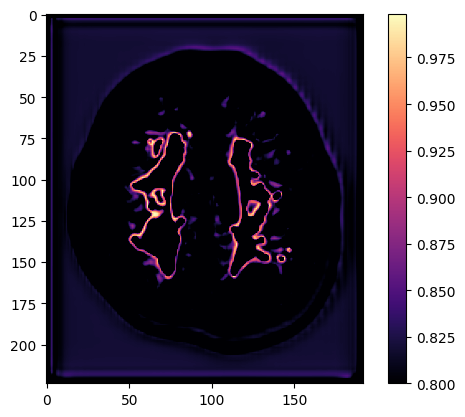

In [47]:
plt.imshow(ent_maps[2][:,:,40].T/1.1, cmap='magma', vmin=0.8); plt.colorbar();

In [45]:
-np.log(0.33)

1.1086626245216111